<a href="https://colab.research.google.com/github/mawady/cv-recipes/blob/main/ObjectSegmentationPanopticAndSemantic_Infer_Mask2Former_Cityscapes_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# refs:
# https://github.com/NielsRogge/Transformers-Tutorials/blob/master/Mask2Former/Inference_with_Mask2Former.ipynb
# https://huggingface.co/facebook/mask2former-swin-tiny-cityscapes-semantic
# https://huggingface.co/facebook/mask2former-swin-tiny-cityscapes-panoptic
# https://huggingface.co/facebook/mask2former-swin-tiny-cityscapes-instance

In [2]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [3]:
!wget https://upload.wikimedia.org/wikipedia/commons/b/ba/Broad_Street%2C_Reading.jpg -O input.jpg

--2024-02-28 19:56:29--  https://upload.wikimedia.org/wikipedia/commons/b/ba/Broad_Street%2C_Reading.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.154.240, 2620:0:861:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.154.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94156 (92K) [image/jpeg]
Saving to: ‘input.jpg’

input.jpg           100%[===================>]  91.95K  --.-KB/s    in 0.03s   

2024-02-28 19:56:29 (2.85 MB/s) - ‘input.jpg’ saved [94156/94156]



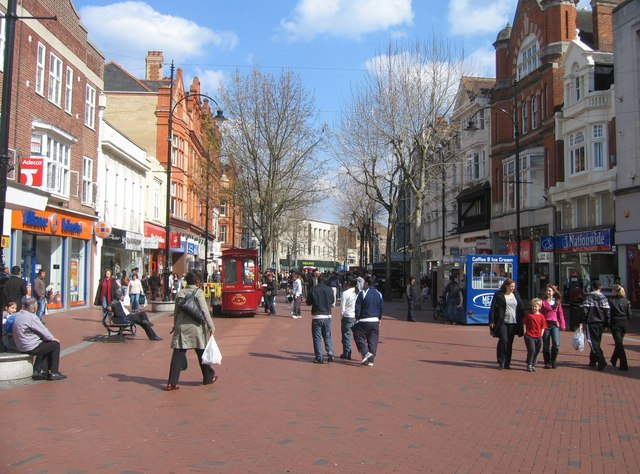

In [4]:
from PIL import Image
image = Image.open("input.jpg")
image

In [5]:
from transformers import AutoImageProcessor, Mask2FormerForUniversalSegmentation
import torch

# processor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-base-coco-panoptic")
# model = Mask2FormerForUniversalSegmentation.from_pretrained("facebook/mask2former-swin-base-coco-panoptic")
processor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-tiny-cityscapes-panoptic")
model = Mask2FormerForUniversalSegmentation.from_pretrained("facebook/mask2former-swin-tiny-cityscapes-panoptic")

inputs = processor(images=image, return_tensors="pt")
# for k,v in inputs.items():
#   print(k,v.shape)

with torch.no_grad():
  outputs = model(**inputs)

results = processor.post_process_panoptic_segmentation(outputs, target_sizes=[image.size[::-1]])[0]
# print(results.keys())

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
`label_ids_to_fuse` unset. No instance will be fused.


<ipython-input-6-297610d119f1>:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = cm.get_cmap('viridis', torch.max(segmentation))


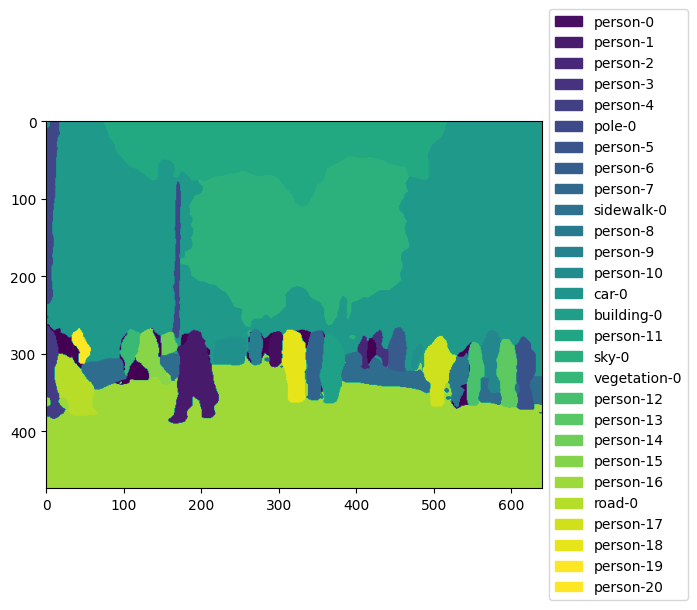

In [6]:
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import cm

def draw_panoptic_segmentation(segmentation, segments_info):
    # get the used color map
    viridis = cm.get_cmap('viridis', torch.max(segmentation))
    fig, ax = plt.subplots()
    ax.imshow(segmentation)
    instances_counter = defaultdict(int)
    handles = []
    # for each segment, draw its legend
    for segment in segments_info:
        segment_id = segment['id']
        segment_label_id = segment['label_id']
        segment_label = model.config.id2label[segment_label_id]
        label = f"{segment_label}-{instances_counter[segment_label_id]}"
        instances_counter[segment_label_id] += 1
        color = viridis(segment_id)
        handles.append(mpatches.Patch(color=color, label=label))

    ax.legend(handles=handles, loc='center left', bbox_to_anchor=(1, 0.5))

draw_panoptic_segmentation(**results)

In [7]:
from transformers import AutoImageProcessor, Mask2FormerForUniversalSegmentation
import numpy as np

processor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-tiny-cityscapes-semantic")
model = Mask2FormerForUniversalSegmentation.from_pretrained("facebook/mask2former-swin-tiny-cityscapes-semantic")

inputs = processor(images=image, return_tensors="pt")
with torch.no_grad():
  outputs = model(**inputs)
predicted_map = processor.post_process_semantic_segmentation(outputs, target_sizes=[image.size[::-1]])[0]
# print(predicted_map.shape)
color_palette = [list(np.random.choice(range(256), size=3)) for _ in range(len(model.config.id2label))]
# print(color_palette)

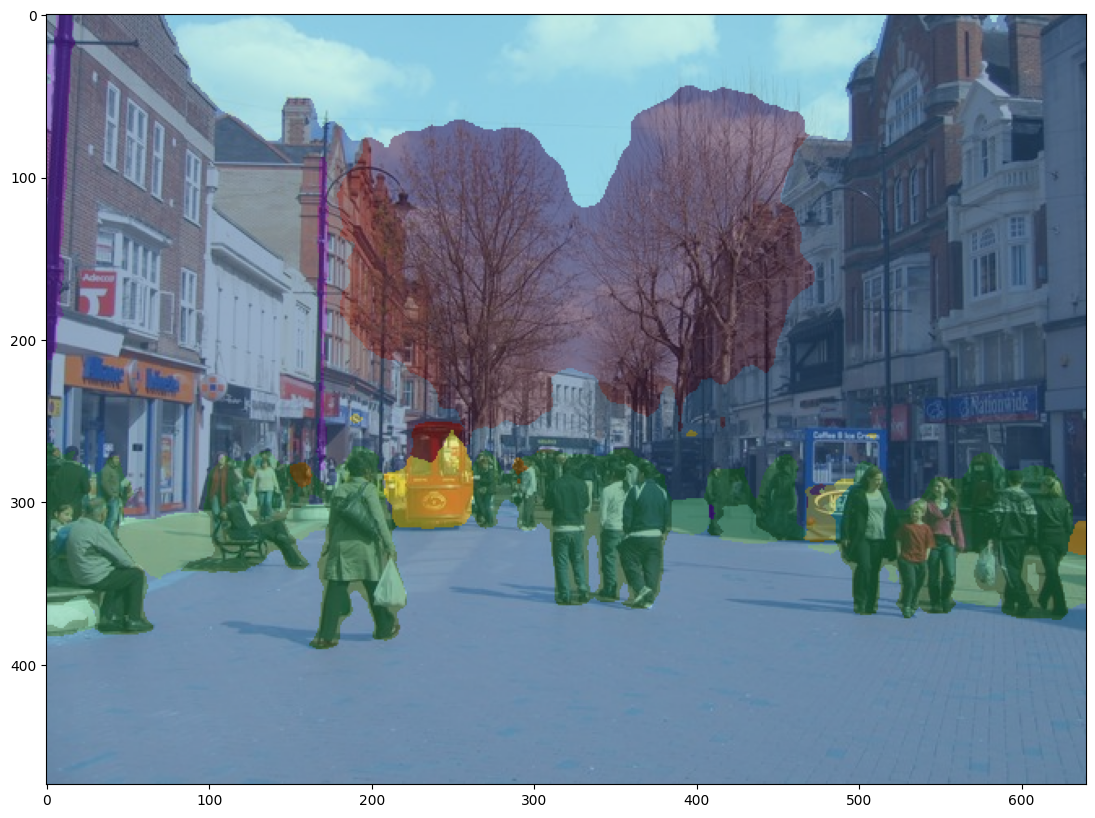

In [8]:
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

seg = predicted_map
color_seg = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8) # height, width, 3
palette = np.array(color_palette)
for label, color in enumerate(palette):
    color_seg[seg == label, :] = color
# Convert to BGR
color_seg = color_seg[..., ::-1]

# Show image + mask
img = np.array(image) * 0.5 + color_seg * 0.5
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()